In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [3]:
#import tensorflow_datasets as tfds
import pandas as pd
%matplotlib inline

## Dataset

Download e preparação dos dados

In [ ]:
# Esta célula faz o download do dataset completo
#Sample_dataset = tfds.load("oxford_iiit_pet", split="train", try_gcs=True)
#assert isinstance(Sample_dataset, tf.data.Dataset)
#Sample_dataset

In [4]:
path_csv = "./oxford_iiit_pet.csv"
path_images = "C:/Users/LEO/tensorflow_datasets/downloads/extracted/pets_images/images/"
formato = [".jpg", ".png"]

# Nesse dataset, os dados são separados por espaços, e as colunas não vem nomeadas
# por isso o seguinte tratamento
oxford_iiit_pet_dataset = pd.read_csv(path_csv, sep = " ", names ="Image CLASS_ID SPECIES BREED_ID".split())

# As imagens estão registradas apenas com o nome, então é adicionado o caminho local
# e em seguida é transformada em uma matriz compreensível para o matplotlib
oxford_iiit_pet_dataset["Image"] = [path_images + str(nome_img) + formato[0] for nome_img in oxford_iiit_pet_dataset["Image"]]


<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>


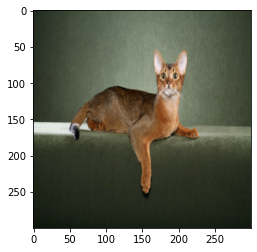

In [26]:
imagem = plt.imread(path_images + "Abyssinian_1.jpg")
print(type(imagem))

imagem = tf.image.resize(imagem, (300,300))
print(type(imagem))


from keras.preprocessing.image import array_to_img, img_to_array
imagem  = img_to_array(imagem)
print(type(imagem))

#print(imagem)                          
plt.imshow(array_to_img(imagem))

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

def preProcessingImages(imagem):
    imagem  = plt.imread(imagem) # retorna um numpy array
    imagem = tf.image.resize(imagem, (300,300)) # retorna um Tensorflow 
    #| essa acima é a função que vai deixar todas as imagens com as mesmas dimensões
    imagem = img_to_array(imagem)  # retorna um numpy array
    return imagem

In [7]:
#oxford_iiit_pet_dataset["Image"] = [preProcessingImages(img) for img in oxford_iiit_pet_dataset["Image"]] 
oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize((300, 300), Image.ANTIALIAS) for img in oxford_iiit_pet_dataset["Image"]])
oxford_iiit_pet_dataset.tail() # as últimas linhas do dataframe

C:\Users\LEO\AppData\Local\Temp/ipykernel_3812/1552477993.py:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize((300, 300), Image.ANTIALIAS) for img in oxford_iiit_pet_dataset["Image"]])
C:\Users\LEO\AppData\Local\Temp/ipykernel_3812/1552477993.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

,Image,CLASS_ID,SPECIES,BREED_ID
3675,<PIL.Image.Image image mode=RGB size=300x300 a...,37,2,25
3676,<PIL.Image.Image image mode=RGB size=300x300 a...,37,2,25
3677,<PIL.Image.Image image mode=RGB size=300x300 a...,37,2,25
3678,<PIL.Image.Image image mode=RGB size=300x300 a...,37,2,25
3679,<PIL.Image.Image image mode=RGB size=300x300 a...,37,2,25


In [13]:
oxford_iiit_pet_dataset["Image"] = [img_to_array(img) for img in oxford_iiit_pet_dataset["Image"]]
oxford_iiit_pet_dataset.tail() # as últimas linhas do dataframe

,Image,CLASS_ID,SPECIES,BREED_ID
3675,"[[[243.0, 208.0, 148.0], [243.0, 211.0, 147.0]...",37,2,25
3676,"[[[5.0, 5.0, 5.0], [6.0, 6.0, 6.0], [5.0, 5.0,...",37,2,25
3677,"[[[41.0, 32.0, 23.0], [37.0, 31.0, 20.0], [38....",37,2,25
3678,"[[[84.0, 114.0, 116.0], [84.0, 114.0, 116.0], ...",37,2,25
3679,"[[[127.0, 116.0, 110.0], [127.0, 117.0, 108.0]...",37,2,25


In [56]:
classes_names = ['gato', 'cachorro'] # 1: gato, 2: cachorro

## Separação dos dados de treino e de teste

In [15]:
X = oxford_iiit_pet_dataset["Image"] # Conjunto de dados
y = oxford_iiit_pet_dataset["SPECIES"] # Conjunto "alvo / classe"

In [16]:
print(X.shape)
print(X[0].shape)
print(type(X), type(y))

(3680,)
(300, 300, 3)
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [17]:
# divisão dos dados de teste (60%) e treino (40%)
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=101)
print(type(train_images), type(train_labels))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [18]:
print(len(train_labels))
print(train_images.shape)
print(test_images.shape)

2208
(2208,)
(1472,)


In [34]:
n = np.asarray([train_images[x] for x in train_images.index])
m = np.asarray([test_images[x] for x in test_images.index])

print(n.shape, "\t", m.shape)

(2208, 300, 300, 3) 	 (1472, 300, 300, 3)


In [35]:
train_images = n
test_images = m

# Pré-processamento dos dados

Inspeção da primeira imagem

IMG shape (300, 300, 3)


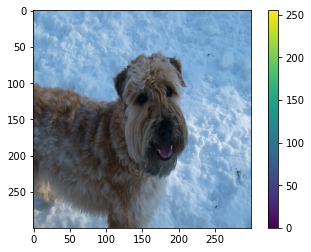

In [39]:
from keras.preprocessing.image import array_to_img
print("IMG shape", train_images[0].shape)
plt.figure()
plt.imshow(array_to_img(train_images[0]))
plt.colorbar()
plt.grid(False)
plt.show()

Escalaremos esses valores no intervalo de 0 e 1

In [40]:
train_images = train_images / 255.0

test_images = test_images / 255.0

## Verificar que os dados estão no formato correto

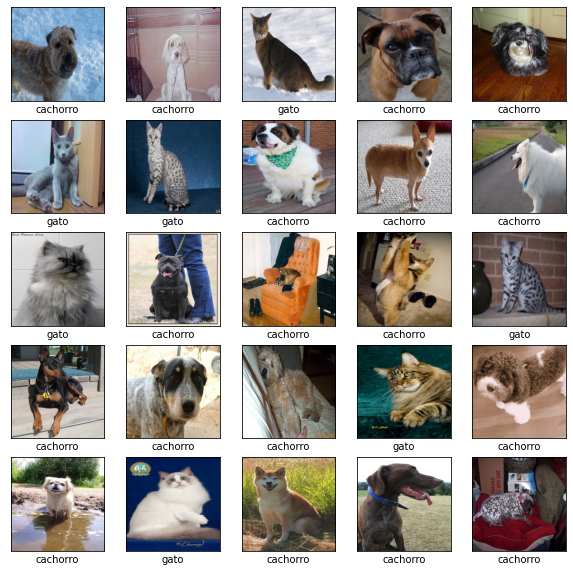

In [26]:
plt.figure(figsize=(10,10))

for i,x in enumerate(list(train_images.index[:25])):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(array_to_img(train_images[x]), cmap=plt.cm.binary)
    plt.xlabel(classes_names[train_labels[x] - 1])
plt.show()

# Contrução do Modelo

In [41]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(300, 300, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [42]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
print(type(train_labels)) # numpy.ndarray | pandas
print(type(train_images)) # list | numpy
print(type(test_labels), test_labels.shape) 
print(type(test_images), test_images.shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'> (1472,)
<class 'pandas.core.series.Series'> (1472,)


In [43]:
model.fit( tf.expand_dims(train_images, axis=-1) , train_labels, epochs=10)

Epoch 1/10
69/69 [==============================] - 126s 2s/step - loss: 0.7123 - accuracy: 0.6345
Epoch 2/10
69/69 [==============================] - 16s 233ms/step - loss: 0.6482 - accuracy: 0.6612
Epoch 3/10
69/69 [==============================] - 15s 220ms/step - loss: 0.6433 - accuracy: 0.6716
Epoch 4/10
69/69 [==============================] - 15s 224ms/step - loss: 0.6107 - accuracy: 0.6889
Epoch 5/10
69/69 [==============================] - 17s 247ms/step - loss: 0.6033 - accuracy: 0.6943
Epoch 6/10
69/69 [==============================] - 16s 238ms/step - loss: 0.5900 - accuracy: 0.7043
Epoch 7/10
69/69 [==============================] - 15s 223ms/step - loss: 0.6131 - accuracy: 0.6816
Epoch 8/10
69/69 [==============================] - 15s 219ms/step - loss: 0.6119 - accuracy: 0.6757
Epoch 9/10
69/69 [==============================] - 15s 220ms/step - loss: 0.6263 - accuracy: 0.6689
Epoch 10/10
69/69 [==============================] - 15s 219ms/step - loss: 0.5670 - accuracy

In [44]:
test_loss, test_acc = model.evaluate( tf.expand_dims(test_images, axis=-1),  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


46/46 - 8s - loss: 0.6484 - accuracy: 0.6630 - 8s/epoch - 175ms/step

Test accuracy: 0.6630434989929199


In [45]:
predictions = model.predict(test_images)


In [46]:
predictions[0]


array([2.1446252e-07, 3.6312476e-01, 6.3686937e-01, 6.2677378e-07,
       1.4791241e-06, 1.1811378e-06, 4.1032837e-07, 5.1440890e-07,
       5.0685509e-07, 1.0784238e-06], dtype=float32)

In [87]:
np.argmax(predictions[0]) 

2

In [111]:
list_of_cats = []
for i in range(1472):
    if np.argmax(predictions[i]) != 2:
        list_of_cats.append(i)
list_of_cats[:5]

[14, 44, 73, 77, 78]

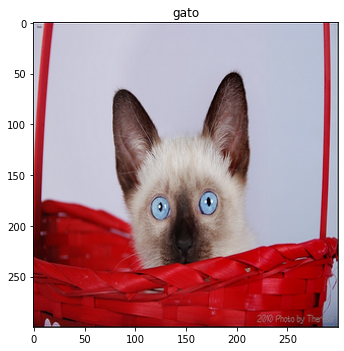

In [113]:
i = 44
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(test_images[i] * 255.)
plt.title(classes_names[np.argmax(predictions[i]) - 1])
plt.show()
